# Extensive regime detection

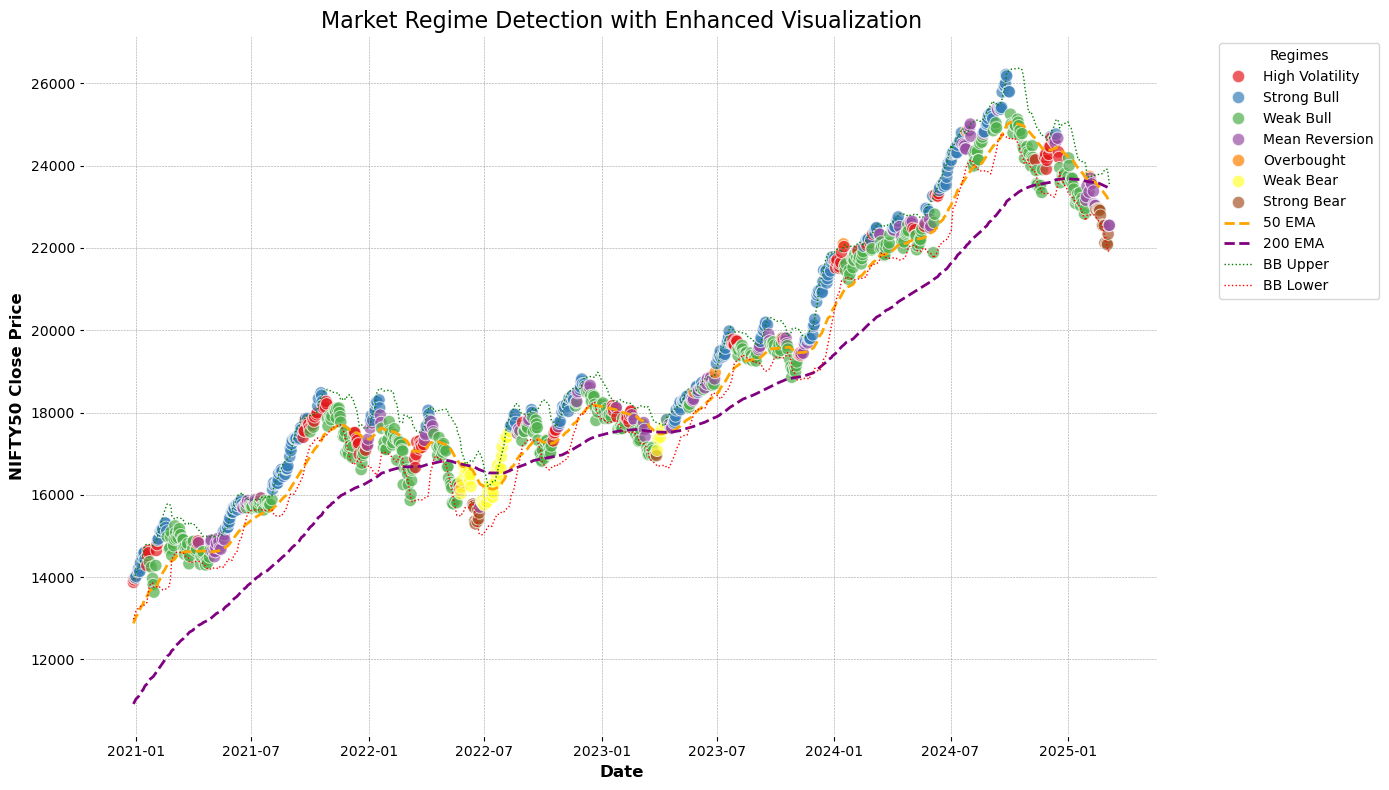

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta

# Load NIFTY50 data (Replace with actual data file)
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

# Compute Indicators using pandas_ta directly
df["50EMA"] = ta.ema(df["Close"], length=50)
df["200EMA"] = ta.ema(df["Close"], length=200)
df["RSI"] = ta.rsi(df["Close"], length=14)
df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
macd = ta.macd(df["Close"], fast=12, slow=26, signal=9)
df["MACD"] = macd["MACD_12_26_9"]
df["Signal"] = macd["MACDs_12_26_9"]
bbands = ta.bbands(df["Close"], length=20)
df["BB_Upper"] = bbands["BBU_20_2.0"]
df["BB_Middle"] = bbands["BBM_20_2.0"]
df["BB_Lower"] = bbands["BBL_20_2.0"]

def detect_regime(row, atr_rolling_mean):
    """Classifies the market into different regimes based on conditions."""
    if row["50EMA"] > row["200EMA"] and row["MACD"] > row["Signal"] and row["RSI"] > 60:
        return "Strong Bull"
    elif row["50EMA"] > row["200EMA"] and row["MACD"] < row["Signal"] and row["RSI"] < 60:
        return "Weak Bull"
    elif row["50EMA"] < row["200EMA"] and row["MACD"] < row["Signal"] and row["RSI"] < 40:
        return "Strong Bear"
    elif row["50EMA"] < row["200EMA"] and row["MACD"] > row["Signal"] and row["RSI"] > 40:
        return "Weak Bear"
    elif row["Close"] > row["BB_Upper"]:
        return "Overbought"
    elif row["Close"] < row["BB_Lower"]:
        return "Oversold"
    elif row["ATR"] > atr_rolling_mean:
        return "High Volatility"
    else:
        return "Mean Reversion"

# Calculate rolling mean for ATR
atr_rolling_mean = df["ATR"].rolling(50).mean()

# Apply Regime Classification
df.dropna(inplace=True)
df["Regime"] = df.apply(lambda row: detect_regime(row, atr_rolling_mean[row.name]), axis=1)

# Visualization
plt.figure(figsize=(14, 8))

# Scatterplot with color distinction for regimes
sns.scatterplot(data=df, x=df.index, y="Close", hue="Regime", palette="Set1", alpha=0.7, s=80)

# Plotting Moving Averages
plt.plot(df.index, df["50EMA"], label="50 EMA", color="orange", linewidth=2, linestyle='--')
plt.plot(df.index, df["200EMA"], label="200 EMA", color="purple", linewidth=2, linestyle='--')

# Plotting Bollinger Bands
plt.plot(df.index, df["BB_Upper"], label="BB Upper", color="green", linestyle=':', linewidth=1)
plt.plot(df.index, df["BB_Lower"], label="BB Lower", color="red", linestyle=':', linewidth=1)

# Adding titles, labels, and legend
plt.title("Market Regime Detection with Enhanced Visualization", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("NIFTY50 Close Price", fontsize=12)
plt.legend(title="Regimes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
df.to_csv('extensive_regime_detection.csv')

# Price Action Analysis

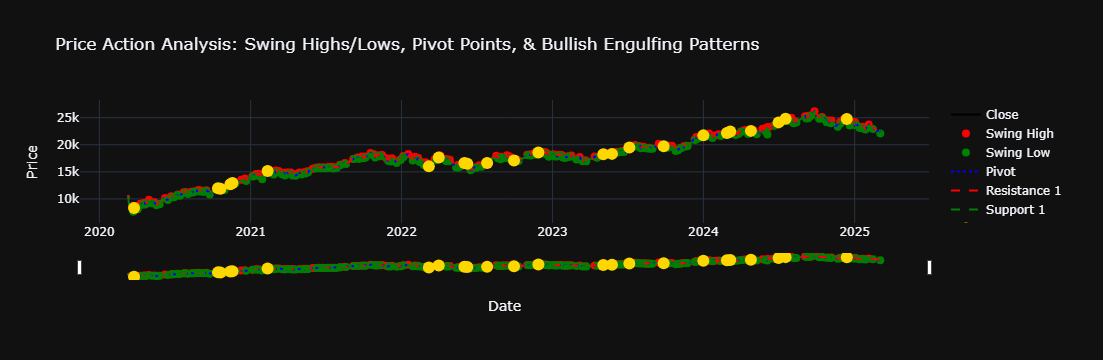

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load NIFTY50 data (Replace with your actual data file)
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

# --- 1. Detect Swing Highs and Swing Lows ---
# Using a rolling window to identify local maximums (swing highs) and minimums (swing lows)
window = 5  # Adjust based on desired sensitivity
df["swing_high"] = df["Close"][(df["Close"] == df["Close"].rolling(window=window, center=True).max())]
df["swing_low"] = df["Close"][(df["Close"] == df["Close"].rolling(window=window, center=True).min())]

# --- 2. Calculate Pivot Points (Support/Resistance Levels) ---
# Pivot point formulas (for daily data):
# Pivot (P) = (High + Low + Close) / 3
# Resistance 1 (R1) = 2P - Low, Support 1 (S1) = 2P - High
df["Pivot"] = (df["High"] + df["Low"] + df["Close"]) / 3
df["R1"] = 2 * df["Pivot"] - df["Low"]
df["S1"] = 2 * df["Pivot"] - df["High"]

# --- 3. Candlestick Pattern Recognition: Bullish Engulfing ---
def bullish_engulfing(data):
    """
    Identify bullish engulfing patterns:
    - Previous candle is bearish (Close < Open)
    - Current candle is bullish (Close > Open)
    - Current candle's body fully engulfs the previous candle's body
    """
    pattern = [False]  # First row has no prior candle to compare
    for i in range(1, len(data)):
        prev = data.iloc[i-1]
        curr = data.iloc[i]
        if (prev["Close"] < prev["Open"] and              # Previous candle bearish
            curr["Close"] > curr["Open"] and              # Current candle bullish
            curr["Open"] < prev["Close"] and              # Current open below previous close
            curr["Close"] > prev["Open"]):                # Current close above previous open
            pattern.append(True)
        else:
            pattern.append(False)
    return pattern

df["BullishEngulfing"] = bullish_engulfing(df)

# --- Create the Interactive Chart using Plotly ---
fig = go.Figure()

# Plot the closing price as a line
fig.add_trace(go.Scatter(x=df.index, y=df["Close"],
                         mode="lines", name="Close",
                         line=dict(color="black", width=2)))

# Plot Swing Highs and Swing Lows as markers
fig.add_trace(go.Scatter(x=df.index, y=df["swing_high"],
                         mode="markers", name="Swing High",
                         marker=dict(color="red", size=8)))
fig.add_trace(go.Scatter(x=df.index, y=df["swing_low"],
                         mode="markers", name="Swing Low",
                         marker=dict(color="green", size=8)))

# Plot Pivot, Resistance, and Support lines
fig.add_trace(go.Scatter(x=df.index, y=df["Pivot"],
                         mode="lines", name="Pivot",
                         line=dict(color="blue", dash="dot")))
fig.add_trace(go.Scatter(x=df.index, y=df["R1"],
                         mode="lines", name="Resistance 1",
                         line=dict(color="red", dash="dash")))
fig.add_trace(go.Scatter(x=df.index, y=df["S1"],
                         mode="lines", name="Support 1",
                         line=dict(color="green", dash="dash")))

# Highlight Bullish Engulfing patterns as markers
engulfing_signals = df[df["BullishEngulfing"]]
fig.add_trace(go.Scatter(x=engulfing_signals.index, y=engulfing_signals["Close"],
                         mode="markers", name="Bullish Engulfing",
                         marker=dict(color="gold", size=12)))

# Update layout for better visualization
fig.update_layout(
    title="Price Action Analysis: Swing Highs/Lows, Pivot Points, & Bullish Engulfing Patterns",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    hovermode="x unified",
    xaxis_rangeslider_visible=True,
    height=700
)

# Show the plot
fig.show()


In [4]:
df.to_csv('price_action.csv')

# price action with candlestick action

C:\ProgramData\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




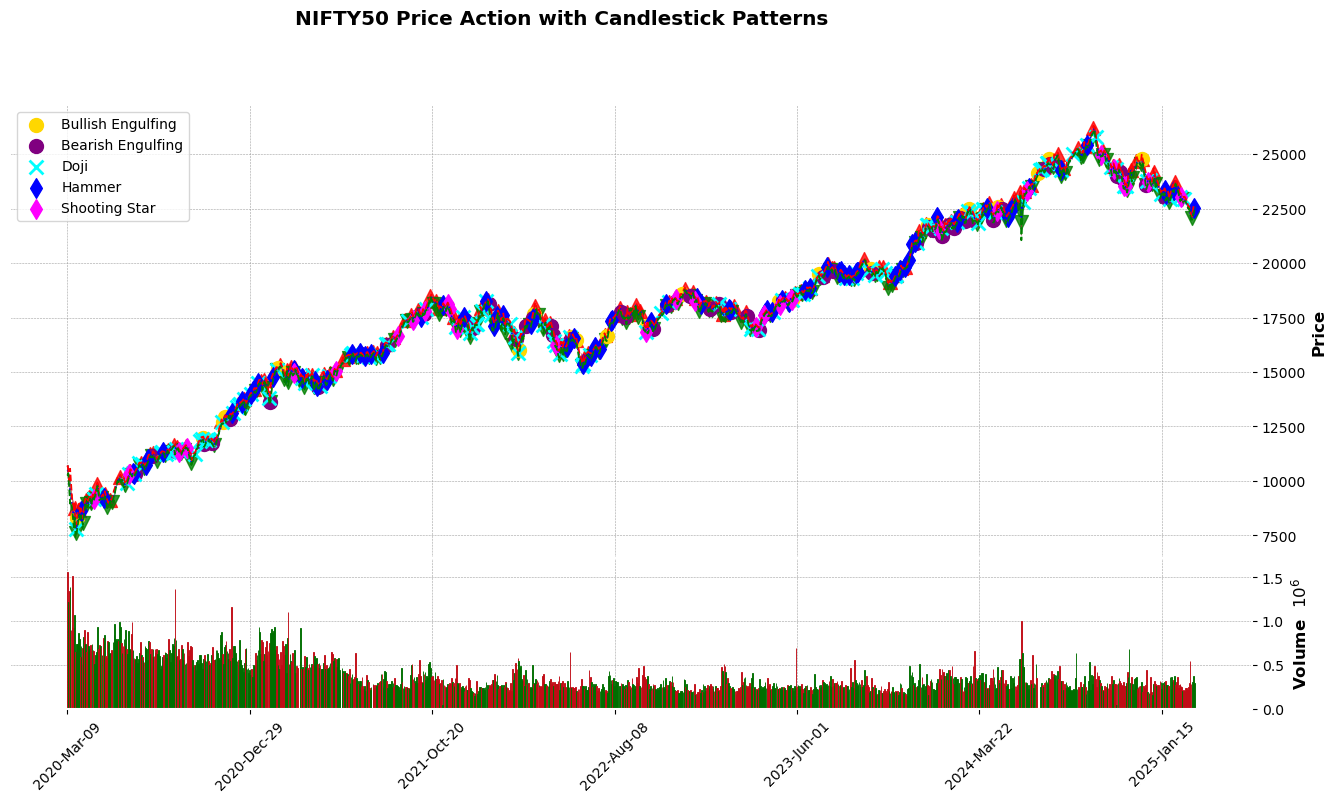

In [19]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# Load NIFTY50 data
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

# --- 1. Detect Swing Highs and Swing Lows ---
window = 5  # Adjust for sensitivity
df["Swing_High"] = df["Close"][(df["Close"] == df["Close"].rolling(window=window, center=True).max())]
df["Swing_Low"] = df["Close"][(df["Close"] == df["Close"].rolling(window=window, center=True).min())]

# --- 2. Calculate Pivot Points (Support/Resistance Levels) ---
df["Pivot"] = (df["High"] + df["Low"] + df["Close"]) / 3
df["R1"] = 2 * df["Pivot"] - df["Low"]
df["S1"] = 2 * df["Pivot"] - df["High"]

# --- 3. Candlestick Pattern Recognition ---
def detect_patterns(data):
    bullish_engulfing = []
    bearish_engulfing = []
    doji = []
    hammer = []
    shooting_star = []

    for i in range(1, len(data)):
        prev = data.iloc[i-1]
        curr = data.iloc[i]
        
        # Bullish Engulfing
        if (prev["Close"] < prev["Open"] and  
            curr["Close"] > curr["Open"] and  
            curr["Open"] < prev["Close"] and  
            curr["Close"] > prev["Open"]):  
            bullish_engulfing.append(curr["Close"])
        else:
            bullish_engulfing.append(np.nan)
        
        # Bearish Engulfing
        if (prev["Close"] > prev["Open"] and  
            curr["Close"] < curr["Open"] and  
            curr["Open"] > prev["Close"] and  
            curr["Close"] < prev["Open"]):  
            bearish_engulfing.append(curr["Close"])
        else:
            bearish_engulfing.append(np.nan)

        # Doji (Small body, Open ≈ Close)
        if abs(curr["Open"] - curr["Close"]) <= (curr["High"] - curr["Low"]) * 0.1:
            doji.append(curr["Close"])
        else:
            doji.append(np.nan)

        # Hammer (Small body, long lower shadow)
        if (curr["Close"] > curr["Open"] and  
            (curr["Open"] - curr["Low"]) > 2 * abs(curr["Open"] - curr["Close"]) and  
            (curr["High"] - curr["Close"]) < 0.3 * (curr["High"] - curr["Low"])):
            hammer.append(curr["Close"])
        else:
            hammer.append(np.nan)

        # Shooting Star (Small body, long upper shadow)
        if (curr["Close"] < curr["Open"] and  
            (curr["High"] - curr["Open"]) > 2 * abs(curr["Open"] - curr["Close"]) and  
            (curr["Close"] - curr["Low"]) < 0.3 * (curr["High"] - curr["Low"])):
            shooting_star.append(curr["Close"])
        else:
            shooting_star.append(np.nan)

    # First row should be NaN since there's no previous row for comparison
    bullish_engulfing.insert(0, np.nan)
    bearish_engulfing.insert(0, np.nan)
    doji.insert(0, np.nan)
    hammer.insert(0, np.nan)
    shooting_star.insert(0, np.nan)

    data["Bullish_Engulfing"] = bullish_engulfing
    data["Bearish_Engulfing"] = bearish_engulfing
    data["Doji"] = doji
    data["Hammer"] = hammer
    data["Shooting_Star"] = shooting_star


detect_patterns(df)



# --- 4. Visualization with mplfinance ---
# Custom markers for patterns
apdict = [
    mpf.make_addplot(df["Swing_High"], scatter=True, markersize=100, marker="^", color="red", alpha=0.8),  # Swing High
    mpf.make_addplot(df["Swing_Low"], scatter=True, markersize=100, marker="v", color="green", alpha=0.8),  # Swing Low
    mpf.make_addplot(df["Pivot"], color="blue", linestyle="dotted"),  # Pivot Line
    mpf.make_addplot(df["R1"], color="red", linestyle="dashed"),  # Resistance 1
    mpf.make_addplot(df["S1"], color="green", linestyle="dashed"),  # Support 1
    mpf.make_addplot(df["Bullish_Engulfing"], scatter=True, markersize=100, marker="o", color="gold", label="Bullish Engulfing"),
    mpf.make_addplot(df["Bearish_Engulfing"], scatter=True, markersize=100, marker="o", color="purple", label="Bearish Engulfing"),
    mpf.make_addplot(df["Doji"], scatter=True, markersize=100, marker="x", color="cyan", label="Doji"),
    mpf.make_addplot(df["Hammer"], scatter=True, markersize=100, marker="d", color="blue", label="Hammer"),
    mpf.make_addplot(df["Shooting_Star"], scatter=True, markersize=100, marker="d", color="magenta", label="Shooting Star"),
]

# Create the candlestick chart
mpf.plot(df, type="candle", style="charles",
         title="NIFTY50 Price Action with Candlestick Patterns",
         ylabel="Price",
         volume=True,
         addplot=apdict,
         figscale=1.5,
         figratio=(18,9),
         panel_ratios=(6,2))

In [20]:
df.to_csv('price_action_with_candle_stick.csv')

# more comprehensive detection

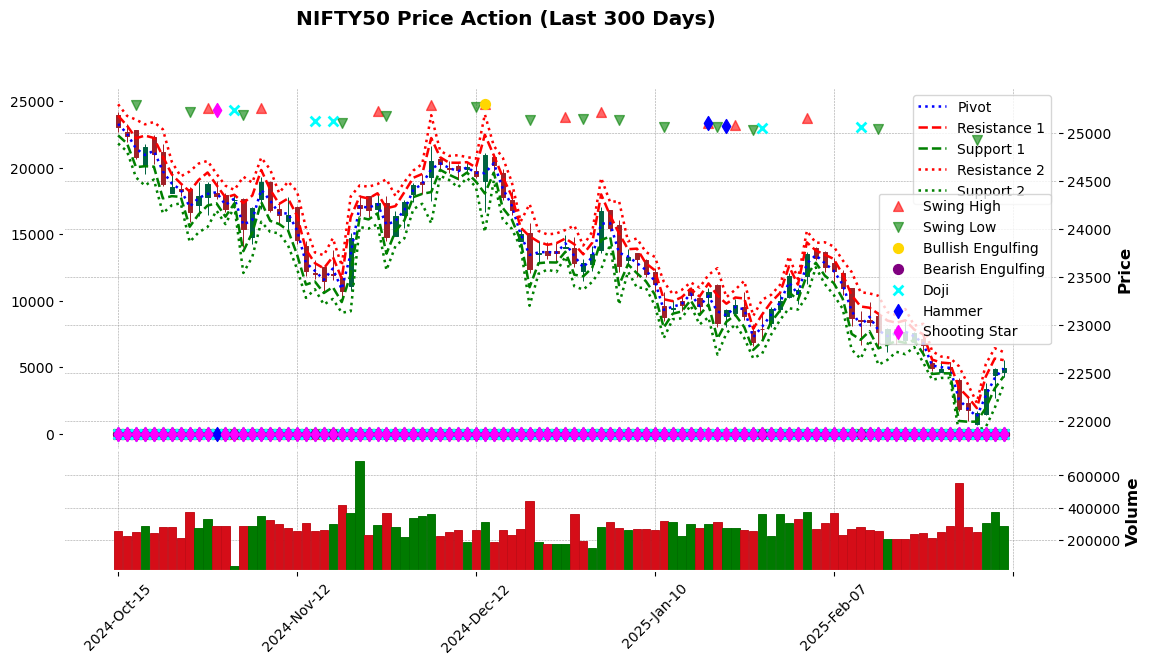

In [24]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# Load Data
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

# Ensure the index is in ascending order
df = df.sort_index()

# --- 1. Verify & Clean Data ---
# Ensure OHLC data has no missing values
df = df.dropna(subset=["Open", "High", "Low", "Close"])

# Ensure the correct data types
df[["Open", "High", "Low", "Close"]] = df[["Open", "High", "Low", "Close"]].astype(float)

# --- 2. Detect Swing Highs and Lows ---
window = 5

df["Swing_High"] = df["Close"][
    (df["Close"] == df["Close"].rolling(window=window, center=True).max()) &
    (df["Close"].shift(1) < df["Close"]) & (df["Close"].shift(-1) < df["Close"])
]

df["Swing_Low"] = df["Close"][
    (df["Close"] == df["Close"].rolling(window=window, center=True).min()) &
    (df["Close"].shift(1) > df["Close"]) & (df["Close"].shift(-1) > df["Close"])
]

# --- 3. Pivot Points & Additional Support/Resistance ---
df["Pivot"] = (df["High"] + df["Low"] + df["Close"]) / 3
df["R1"] = 2 * df["Pivot"] - df["Low"]
df["S1"] = 2 * df["Pivot"] - df["High"]
df["R2"] = df["Pivot"] + (df["R1"] - df["S1"])
df["S2"] = df["Pivot"] - (df["R1"] - df["S1"])

# --- 4. Enhanced Candlestick Pattern Detection ---
def detect_patterns(data):
    bullish_engulfing = []
    bearish_engulfing = []
    doji = []
    hammer = []
    shooting_star = []

    for i in range(1, len(data)):
        prev = data.iloc[i - 1]
        curr = data.iloc[i]

        # Bullish Engulfing
        if (prev["Close"] < prev["Open"] and curr["Close"] > curr["Open"] and
            curr["Open"] < prev["Close"] and curr["Close"] > prev["Open"] and
            (curr["Close"] - curr["Open"]) > (prev["Open"] - prev["Close"]) * 1.2):
            bullish_engulfing.append(curr["Close"])
        else:
            bullish_engulfing.append(np.nan)

        # Bearish Engulfing
        if (prev["Close"] > prev["Open"] and curr["Close"] < curr["Open"] and
            curr["Open"] > prev["Close"] and curr["Close"] < prev["Open"] and
            (prev["Close"] - prev["Open"]) > (curr["Open"] - curr["Close"]) * 1.2):
            bearish_engulfing.append(curr["Close"])
        else:
            bearish_engulfing.append(np.nan)

        # Doji
        body_size = abs(curr["Open"] - curr["Close"])
        total_range = curr["High"] - curr["Low"]
        if body_size <= total_range * 0.05:
            doji.append(curr["Close"])
        else:
            doji.append(np.nan)

        # Hammer
        lower_wick = curr["Open"] - curr["Low"]
        upper_wick = curr["High"] - curr["Close"]
        if (i >= 3 and prev["Close"] < data.iloc[i - 3]["Close"] and
            curr["Close"] > curr["Open"] and lower_wick > 2 * body_size and upper_wick < 0.3 * total_range):
            hammer.append(curr["Close"])
        else:
            hammer.append(np.nan)

        # Shooting Star
        lower_wick = curr["Close"] - curr["Low"]
        upper_wick = curr["High"] - curr["Open"]
        if (i >= 3 and prev["Close"] > data.iloc[i - 3]["Close"] and
            curr["Close"] < curr["Open"] and upper_wick > 2 * body_size and lower_wick < 0.3 * total_range):
            shooting_star.append(curr["Close"])
        else:
            shooting_star.append(np.nan)

    bullish_engulfing.insert(0, np.nan)
    bearish_engulfing.insert(0, np.nan)
    doji.insert(0, np.nan)
    hammer.insert(0, np.nan)
    shooting_star.insert(0, np.nan)

    data["Bullish_Engulfing"] = bullish_engulfing
    data["Bearish_Engulfing"] = bearish_engulfing
    data["Doji"] = doji
    data["Hammer"] = hammer
    data["Shooting_Star"] = shooting_star

# Apply Pattern Detection
detect_patterns(df)

# --- 5. Fix Data Issues Before Plotting ---
df.fillna(0, inplace=True)  # Prevents mplfinance crashes

# Reduce dataset size for better visualization (last 300 days)
df_plot = df.tail(100)

# --- 6. Visualization with mplfinance ---
apdict = [
    mpf.make_addplot(df_plot["Swing_High"], scatter=True, markersize=50, marker="^", color="red", alpha=0.6, label="Swing High"),
    mpf.make_addplot(df_plot["Swing_Low"], scatter=True, markersize=50, marker="v", color="green", alpha=0.6, label="Swing Low"),
    mpf.make_addplot(df_plot["Pivot"], color="blue", linestyle="dotted", label="Pivot"),
    mpf.make_addplot(df_plot["R1"], color="red", linestyle="dashed", label="Resistance 1"),
    mpf.make_addplot(df_plot["S1"], color="green", linestyle="dashed", label="Support 1"),
    mpf.make_addplot(df_plot["R2"], color="red", linestyle="dotted", label="Resistance 2"),
    mpf.make_addplot(df_plot["S2"], color="green", linestyle="dotted", label="Support 2"),
    mpf.make_addplot(df_plot["Bullish_Engulfing"], scatter=True, markersize=50, marker="o", color="gold", label="Bullish Engulfing"),
    mpf.make_addplot(df_plot["Bearish_Engulfing"], scatter=True, markersize=50, marker="o", color="purple", label="Bearish Engulfing"),
    mpf.make_addplot(df_plot["Doji"], scatter=True, markersize=50, marker="x", color="cyan", label="Doji"),
    mpf.make_addplot(df_plot["Hammer"], scatter=True, markersize=50, marker="d", color="blue", label="Hammer"),
    mpf.make_addplot(df_plot["Shooting_Star"], scatter=True, markersize=50, marker="d", color="magenta", label="Shooting Star"),
]

# Plot the Candlestick Chart
mpf.plot(df_plot, type="candle", style="charles",
         title="NIFTY50 Price Action (Last 300 Days)",
         ylabel="Price",
         volume=True,
         addplot=apdict,
         figscale=1.2,
         figratio=(18,9),
         panel_ratios=(6,2))


In [22]:
df.to_csv('price_action_with_candle_stick_2.csv')